In [7]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import json
import httpx
import csv
import zstandard as zstd
import io
import yfinance as yf
from dateutil.relativedelta import relativedelta
from httpx import HTTPStatusError
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
# import pandas_ta as ta
from options_data import *

In [8]:
test = GatherData()
print("[1] getting fundamental data")
fundamental_data = test.get_fundamental_data("GOOGL", "2020-01-01", "2025-01-10")
print("[2] getting historical data")
historical_data = test.get_historical_data(["GOOGL"], "2020-01-01", "2025-01-10")

historical_data = pd.DataFrame.rename(historical_data, columns={"root":"ticker"})
historical_data["date"] =pd.to_datetime(historical_data['date'], format='%Y-%m-%d', errors='coerce')
historical_data = historical_data.drop(columns={"underlying_price"})
historical_data = historical_data[historical_data["right"]=="C"]

fundamental_data["date"] = pd.to_datetime(fundamental_data['date']).dt.date
historical_data["date"] = pd.to_datetime(historical_data['date']).dt.date

print('[1] fundamental data')
df = pd.DataFrame(fundamental_data)
print('[2] added historical data')
df = pd.merge(df, historical_data, how="outer", on=["ticker", "date"])
# print('[3] added liquidity data')
# df = pd.merge(df, liquidity_data, how="outer", on=["date"])
# print('[4] added institutional data')
# df = pd.merge(df, institutional_data, how="outer", on=["ticker", "date"])
# print('[5] added sentiment data')
# df = pd.merge(df, sentiment_data, how="outer", on=["ticker", "date"])
# print('[6] added earnings data')
# df = pd.merge(df, earnings_data, how="outer", on=["ticker", "date"])
# df = pd.merge(df, vix_renamed, how="left", on="date")
df = pd.DataFrame.rename(df, columns={"close_x":"stock_close", "volume_x":"stock_volume", "close_y":"options_close_price"})
df = df.drop(columns={"ticker"})

df["expiration"] = df["expiration"].astype(str)
df["expiration"] = pd.to_datetime(df["expiration"], format="%Y-%m-%d", errors="coerce")
print(df["expiration"][df["expiration"].isna()])
# df["expiration"] = pd.to_datetime(historical_data["expiration"], format="%Y-%m-%d", errors="ignore")
# print(df["date"][df["expiration"].isna()])
df["expiration_date"] = df["expiration"]
df["expiration"] = (df["expiration"] - pd.to_datetime(df["date"])).dt.days
df = df.set_index("date")

df = df.drop(columns={"right"})


[1] getting fundamental data
[2] getting historical data
[1] fundamental data
[2] added historical data
0      NaT
1      NaT
2      NaT
3      NaT
4      NaT
        ..
1001   NaT
1002   NaT
1003   NaT
1004   NaT
1005   NaT
Name: expiration, Length: 1006, dtype: datetime64[ns]


In [9]:
# Volatility Calculating from options close price
print(df.columns)

processed_df = df.copy()
# processed_df = processed_df.drop(columns={"high", "low", "stock_close", "open", "adjHigh", "adjLow", "adjOpen"})
processed_df = processed_df[processed_df["options_close_price"] != 0]
# processed_df["implied_vol"] = processed_df["implied_vol"].shift(-1)

processed_df["previous_price"] = processed_df.groupby(["strike", "expiration_date"])["options_close_price"].shift(1)

processed_df["log_return"] = np.log(processed_df["options_close_price"]/processed_df["previous_price"])
# processed_df["log_return"] = processed_df["log_return"].fillna(0)
processed_df["7_day_vol"] = processed_df.groupby(["strike", "expiration_date"])["log_return"].transform(lambda x: x.rolling(window=7).std())
processed_df["7_day_vol_target"] = processed_df.groupby(["strike", "expiration_date"])["7_day_vol"].shift(-7)

processed_df["options_close_price_7_days"] = processed_df["options_close_price"].shift(-7)
processed_df["options_7_day_diff"] = processed_df["options_close_price_7_days"] - processed_df["options_close_price"]
processed_df["implied_forecasted_vol_diff"] = processed_df["implied_vol"] - processed_df["7_day_vol_target"]
processed_df["options_overpriced"] = processed_df["implied_forecasted_vol_diff"] > 0


print(processed_df[(processed_df["strike"] == 1300000) & (processed_df["expiration_date"] == pd.to_datetime("2020-01-17"))][["options_close_price", "implied_vol", "7_day_vol_target", "implied_forecasted_vol_diff", "options_overpriced"]])
# processed_df[["strike", "expiration_date", "options_close_price", "previous_price","log_return","7_day_vol_target"]][1000:]

Index(['stock_close', 'high_x', 'low_x', 'open_x', 'stock_volume', 'adjClose',
       'adjHigh', 'adjLow', 'adjOpen', 'adjVolume', 'divCash', 'splitFactor',
       'expiration', 'strike', 'open_y', 'high_y', 'low_y',
       'options_close_price', 'volume_y', 'count', 'bid', 'bid_size', 'ask',
       'ask_size', 'open_interest', 'delta', 'theta', 'vega', 'rho', 'epsilon',
       'lambda', 'gamma', 'd1', 'd2', 'implied_vol', 'iv_error',
       'expiration_date'],
      dtype='object')
Empty DataFrame
Columns: [options_close_price, implied_vol, 7_day_vol_target, implied_forecasted_vol_diff, options_overpriced]
Index: []


In [10]:
eda = DataVis()
spearman_correlation_matrix = processed_df.corr(method='spearman')
pearson_correlation_matrix = processed_df.corr(method='pearson')
processed_df.dropna(subset = ["7_day_vol_target"], inplace=True)

In [11]:
correlation_price = eda.get_sorted_correlation_pairs(spearman_correlation_matrix, 'options_7_day_diff')

print(correlation_price)

              Variable 1                   Variable 2  Correlation  \
1849  options_7_day_diff                          bid    -0.932613   
1846  options_7_day_diff          options_close_price    -0.932150   
1845  options_7_day_diff                        low_y    -0.931137   
1844  options_7_day_diff                       high_y    -0.930290   
1843  options_7_day_diff                       open_y    -0.929400   
1851  options_7_day_diff                          ask    -0.927836   
1866  options_7_day_diff               previous_price    -0.920261   
1859  options_7_day_diff                       lambda     0.828442   
1861  options_7_day_diff                           d1    -0.813931   
1862  options_7_day_diff                           d2    -0.811042   
1842  options_7_day_diff                       strike     0.715133   
1868  options_7_day_diff                    7_day_vol     0.695844   
1869  options_7_day_diff             7_day_vol_target     0.623467   
1872  options_7_day_

In [12]:
correlation_price[correlation_price["Variable 2"].isin(["implied_vol","7_day_vol_target","options_close_price","options_close_price_7_days","implied_forecasted_vol_diff", "options_overpriced"])]


,Variable 1,Variable 2,Correlation,Abs Correlation
1846,options_7_day_diff,options_close_price,-0.932150,0.932150
1869,options_7_day_diff,7_day_vol_target,0.623467,0.623467
1872,options_7_day_diff,implied_forecasted_vol_diff,-0.453165,0.453165
1870,options_7_day_diff,options_close_price_7_days,-0.226364,0.226364
1873,options_7_day_diff,options_overpriced,-0.180515,0.180515
1863,options_7_day_diff,implied_vol,0.165907,0.165907


<Axes: >

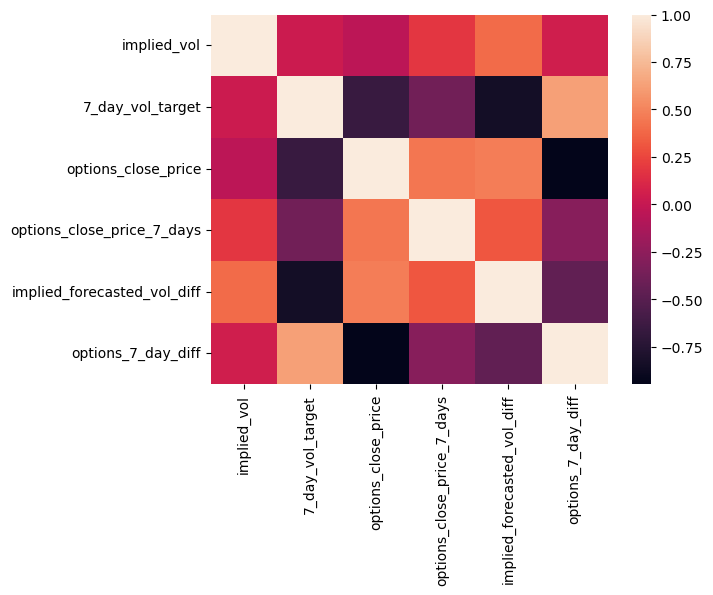

In [13]:
sns.heatmap(processed_df[["implied_vol","7_day_vol_target","options_close_price","options_close_price_7_days","implied_forecasted_vol_diff","options_7_day_diff"]].corr(method='spearman'))

In [14]:
# Basic Model (Assuming we have the predicted futures realized_volatility)

